In [1]:

# from google.colab import drive
# import os

# # Mount Google Drive
# drive.mount('/content/drive')

# # Setup Kaggle credentials
# kaggle_json_path = '/content/drive/MyDrive/Kaggle/kaggle.json'

# # Buat folder .kaggle di root
# os.makedirs('/root/.kaggle', exist_ok=True)

# # Copy kaggle.json ke folder yang tepat
# !cp "{kaggle_json_path}" /root/.kaggle/kaggle.json

# # Set permissions
# !chmod 600 /root/.kaggle/kaggle.json


# print("✓ Google Drive mounted")
# print("✓ Kaggle credentials configured")

In [2]:
!pip install -q kaggle
!pip install -q torchmetrics
!pip install -q timm

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import timm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc, confusion_matrix,
    matthews_corrcoef
)
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✓ All libraries imported successfully


In [3]:
# # Download dataset
# !kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

# # Unzip dataset
# !unzip -q melanoma-skin-cancer-dataset-of-10000-images.zip -d melanoma_dataset

# print("✓ Dataset downloaded and extracted")

# # Cek struktur folder
# !ls -la melanoma_dataset/

In [4]:
# Definisi transformasi untuk training (dengan augmentasi)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Definisi transformasi untuk testing (tanpa augmentasi)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("✓ Data transformations defined")

✓ Data transformations defined


In [5]:
# train_data_path = 'melanoma_dataset/melanoma_cancer_dataset/train'  # Sesuaikan dengan struktur folder
# test_data_path = 'melanoma_dataset/melanoma_cancer_dataset/test'    # Sesuaikan dengan struktur folder

base_path = '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset'

train_data_path = os.path.join(base_path, 'train')
test_data_path = os.path.join(base_path, 'test')

# Load datasets
train_dataset = ImageFolder(root=train_data_path, transform=train_transforms)
test_dataset = ImageFolder(root=test_data_path, transform=test_transforms)

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Testing samples: {len(test_dataset)}")
print(f"✓ Classes: {train_dataset.classes}")
print(f"✓ Class to index mapping: {train_dataset.class_to_idx}")

✓ Training samples: 9605
✓ Testing samples: 1000
✓ Classes: ['benign', 'malignant']
✓ Class to index mapping: {'benign': 0, 'malignant': 1}


In [6]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Test batches: {len(test_loader)}")

✓ Train batches: 301
✓ Test batches: 32


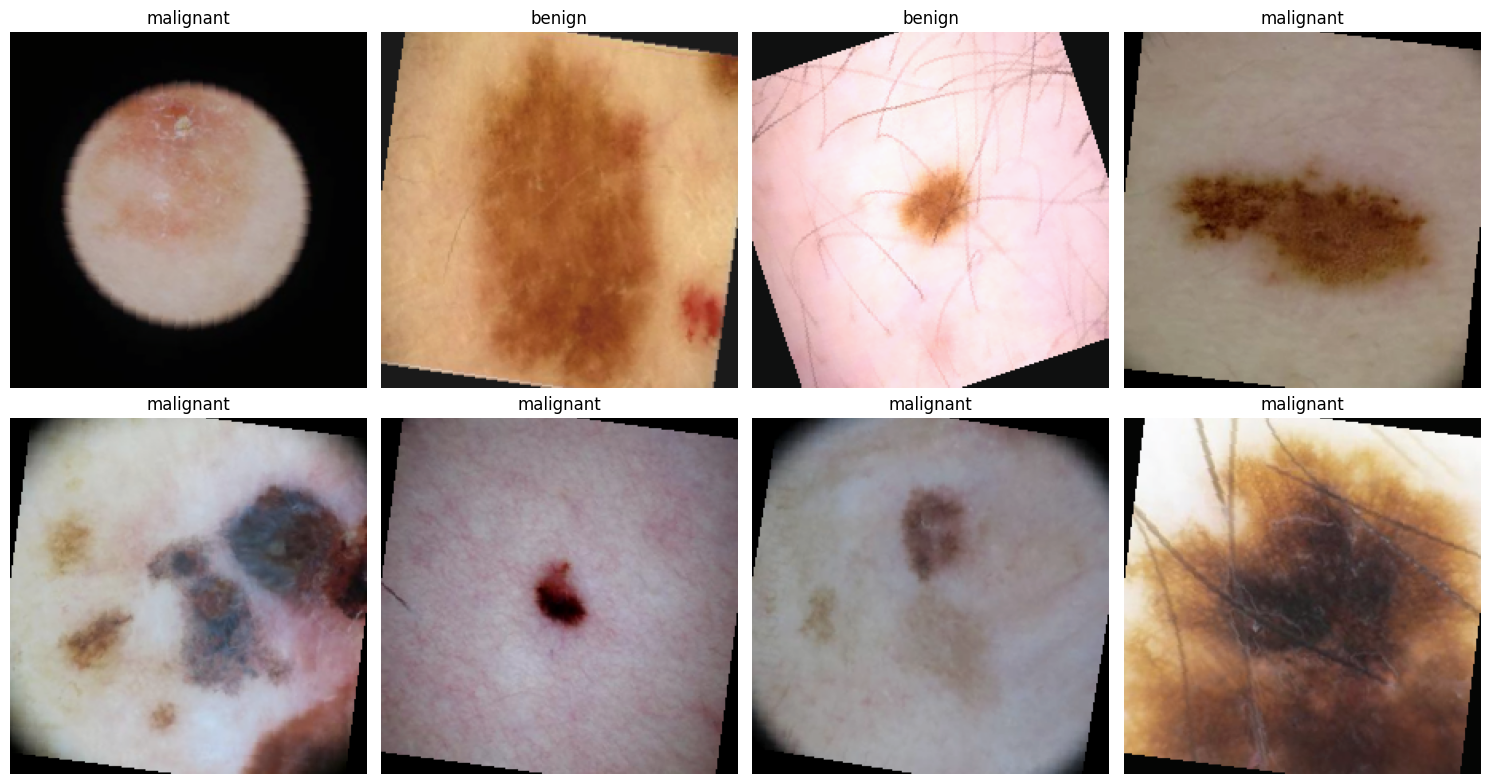

In [7]:
def imshow(img, title):
    """Denormalisasi dan tampilkan gambar"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Ambil batch pertama
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Tampilkan 8 gambar pertama
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for idx in range(8):
    ax = axes[idx // 4, idx % 4]
    plt.sca(ax)
    class_name = train_dataset.classes[labels[idx]]
    imshow(images[idx], f'{class_name}')
plt.tight_layout()
plt.show()

In [8]:
class MelanomaViT(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(MelanomaViT, self).__init__()

        # Load Pretrained Vision Transformer (ViT-Base)
        # 'vit_base_patch16_224' is the standard ImageNet-1k pretrained model
        self.backbone = timm.create_model(
            'vit_base_patch16_224',
            pretrained=pretrained,
            num_classes=0,  # Remove the original classification head
            global_pool='token' # ViT uses the [CLS] token for classification
        )

        # Get the number of input features from the backbone
        # For ViT-Base, this is 768
        num_features = self.backbone.num_features

        # Keep the exact same classifier structure as your previous code
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_features, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        # Extract features
        x = self.backbone(x)
        # Pass through custom classifier
        x = self.classifier(x)
        return x

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

# Initialize model
model = MelanomaViT(num_classes=2, pretrained=True)
model = model.to(device)

print("✓ Vision Transformer (ViT-Base) model initialized")
print(f"✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

# Initialize model
model = MelanomaViT(num_classes=2, pretrained=True)
model = model.to(device)

print("✓ ViT V2 Tiny model initialized")
print(f"✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ Using device: cuda
✓ Vision Transformer (ViT-Base) model initialized
✓ Total parameters: 93,047,482
✓ Using device: cuda
✓ ViT V2 Tiny model initialized
✓ Total parameters: 93,047,482


In [9]:
# Parameter training (disesuaikan karena tidak ada di paper)
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
WEIGHT_DECAY = 1e-4

# Loss function untuk binary classification
criterion = nn.CrossEntropyLoss()

# Optimizer (menggunakan Adam sebagai default)
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
)

print("✓ Loss function and optimizer configured")


✓ Loss function and optimizer configured


In [10]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress
        if (batch_idx + 1) % 50 == 0:
            print(f'  Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc





In [11]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            # Store results
            running_loss += loss.item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilitas kelas positif

    epoch_loss = running_loss / len(test_loader)

    return epoch_loss, all_predictions, all_labels, all_probs




In [12]:
# History untuk tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0
early_stopping_patience = 10

print("Starting training...")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch [{epoch+1}/{NUM_EPOCHS}]')
    print('-' * 60)

    # Training phase
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validation phase
    val_loss, val_preds, val_labels, val_probs = evaluate(
        model, test_loader, criterion, device
    )
    val_acc = 100. * accuracy_score(val_labels, val_preds)

    # Update learning rate
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f'\nEpoch Summary:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_melanoma.pth')
        print(f'  ✓ New best model saved! (Acc: {best_val_acc:.2f}%)')
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    # if patience_counter >= early_stopping_patience:
    #     print(f'\nEarly stopping triggered after {epoch+1} epochs')
    #     break

print("\n" + "="*60)
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch [1/100]
------------------------------------------------------------
  Batch [50/301], Loss: 0.9098, Acc: 54.19%
  Batch [100/301], Loss: 0.6821, Acc: 53.56%
  Batch [150/301], Loss: 0.6927, Acc: 54.40%
  Batch [200/301], Loss: 0.7243, Acc: 54.30%
  Batch [250/301], Loss: 0.6491, Acc: 57.77%
  Batch [300/301], Loss: 0.6117, Acc: 60.21%

Epoch Summary:
  Train Loss: 0.6808, Train Acc: 60.22%
  Val Loss: 0.4859, Val Acc: 83.30%
  ✓ New best model saved! (Acc: 83.30%)

Epoch [2/100]
------------------------------------------------------------
  Batch [50/301], Loss: 0.4271, Acc: 75.25%
  Batch [100/301], Loss: 0.4894, Acc: 78.09%
  Batch [150/301], Loss: 0.3944, Acc: 77.27%
  Batch [200/301], Loss: 0.3619, Acc: 78.05%
  Batch [250/301], Loss: 0.5872, Acc: 78.40%
  Batch [300/301], Loss: 0.6539, Acc: 78.89%

Epoch Summary:
  Train Loss: 0.4931, Train Acc: 78.90%
  Val Loss: 0.3764, Val Acc: 85.30%
  ✓ New best model saved! (Acc: 85.30%)

Epoch [3/100]
----------

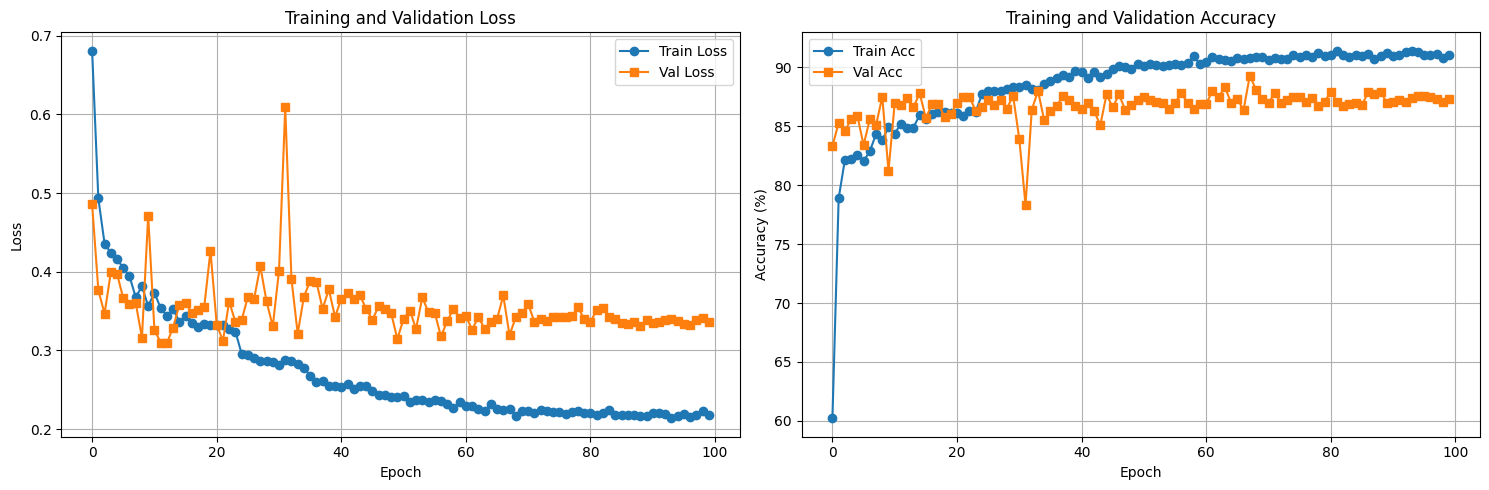

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Load best model
model.load_state_dict(torch.load('best_vit_melanoma.pth'))
print("✓ Best model loaded")

# Final evaluation
_, final_preds, final_labels, final_probs = evaluate(
    model, test_loader, criterion, device
)

print("\n" + "="*60)
print("FINAL EVALUATION RESULTS")
print("="*60)

✓ Best model loaded

FINAL EVALUATION RESULTS


In [15]:
from sklearn.metrics import classification_report

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(final_labels, final_preds).ravel()

# Calculate metrics sesuai paper
accuracy = accuracy_score(final_labels, final_preds) * 100
sensitivity = recall_score(final_labels, final_preds) * 100  # Recall
specificity = (tn / (tn + fp)) * 100
precision = precision_score(final_labels, final_preds) * 100
f1 = f1_score(final_labels, final_preds) * 100
mcc = matthews_corrcoef(final_labels, final_preds) * 100
geometric_mean = np.sqrt(sensitivity * specificity)
error_rate = (1 - accuracy/100) * 100
type1_error = (fp / (fp + tn)) * 100  # False Positive Rate
type2_error = (fn / (fn + tp)) * 100  # False Negative Rate

# ROC Curve dan AUC
fpr, tpr, _ = roc_curve(final_labels, final_probs)
roc_auc = auc(fpr, tpr) * 100

print("\nPerformance Metrics (Target: ViT Paper)")
print("-" * 60)
print(f"Accuracy:              {accuracy:.2f}%  (Target: 87%)")
print(f"Sensitivity (Recall):  {sensitivity:.2f}%  (Target: 82%)")
print(f"Specificity:           {specificity:.2f}%  (Target: 93%)")
print(f"Precision:             {precision:.2f}%  (Target: 91%)")
print(f"F1-Score:              {f1:.2f}%  (Target: 86%)")
print(f"MCC:                   {mcc:.2f}%  (Target: 82%)")
print(f"Geometric Mean:        {geometric_mean:.2f}%  (Target: 84%)")
print(f"Error Rate:            {error_rate:.2f}%  (Target: 12%)")
print(f"Type-I Error (FP):     {type1_error:.2f}%  (Target: 6%)")
print(f"Type-II Error (FN):    {type2_error:.2f}%  (Target: 1.8%)")
print(f"AUC:                   {roc_auc:.2f}%")

print("\nConfusion Matrix:")
print(f"  TN: {tn}, FP: {fp}")
print(f"  FN: {fn}, TP: {tp}")


Performance Metrics (Target: ViT Paper)
------------------------------------------------------------
Accuracy:              89.30%  (Target: 87%)
Sensitivity (Recall):  87.20%  (Target: 82%)
Specificity:           91.40%  (Target: 93%)
Precision:             91.02%  (Target: 91%)
F1-Score:              89.07%  (Target: 86%)
MCC:                   78.67%  (Target: 82%)
Geometric Mean:        89.28%  (Target: 84%)
Error Rate:            10.70%  (Target: 12%)
Type-I Error (FP):     8.60%  (Target: 6%)
Type-II Error (FN):    12.80%  (Target: 1.8%)
AUC:                   95.19%

Confusion Matrix:
  TN: 457, FP: 43
  FN: 64, TP: 436
